# mlbotの初心者向けチュートリアル(BitFlyer版)

richmanbtcさんのmlbotの初心者向けチュートリアルをBitFlyer向けに記載したものです。

## 必要なライブラリのインポート

以下のコードでは必要なライブラリをインポートしています。

In [23]:
import math

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
import datetime,time,requests
from datetime import timedelta

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [24]:
import warnings
warnings.filterwarnings('ignore')

# from pyfeatures import features,calc_features
%load_ext autoreload
%autoreload 2
from pyfeatures import features,calc_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## データを用意
BitFlyerのAPI(チャート用)を利用して1分足のOHLCVを取得します。

In [25]:
# headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

# start_datetime = datetime.datetime.strptime("2022-5-7 00:00:00", "%Y-%m-%d %H:%M:%S")
# end_datetime = datetime.datetime.strptime("2018-01-07 00:00:00", "%Y-%m-%d %H:%M:%S")
# target_coin = "FX_BTC_JPY"


# ohlc_list=[]
# while start_datetime > end_datetime:
#     unixtime = start_datetime.timestamp() * 1000
#     response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
#     ohlc_list.extend(response)
#     start_datetime -= timedelta(minutes=720)
#     time.sleep(1)


# df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
# df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
# df_1m.set_index("timestamp",inplace=True)
# df_1m.sort_index(inplace=True)
# display(df_1m)

# df_1m.to_pickle('df_bf_fx_ohlcv_1m.pkl')

1分足のOHLCVを15分足に変換します。

In [26]:
df_1m = pd.read_pickle('df_bf_fx_ohlcv_1m.pkl')
df_1m = df_1m[df_1m.index.year >= 2020]
rule = "15T"
df = pd.DataFrame()
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

display(df)
df.to_pickle('df_bf_fx_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2020-01-01 00:00:00+00:00,792732.0,792871.0,791214.0,791797.0,692.762261
2020-01-01 00:15:00+00:00,791807.0,792210.0,791334.0,791668.0,465.397858
2020-01-01 00:30:00+00:00,791668.0,792128.0,791409.0,791564.0,216.670723
2020-01-01 00:45:00+00:00,791627.0,792061.0,791165.0,791530.0,353.790308
2020-01-01 01:00:00+00:00,791530.0,792971.0,791406.0,792679.0,480.035723
...,...,...,...,...,...
2022-05-06 11:00:00+00:00,4737209.0,4763389.0,4702323.0,4721553.0,210.899548
2022-05-06 11:15:00+00:00,4721181.0,4728110.0,4687535.0,4709700.0,162.779580
2022-05-06 11:30:00+00:00,4709364.0,4747896.0,4697567.0,4722130.0,167.315703


## maker手数料カラムを追加
0円とする。SFDの手数料の考慮は省略。  
https://bitflyer.com/ja-jp/commission

In [27]:
df = pd.read_pickle('df_bf_fx_ohlcv.pkl')
df['fee'] = 0.0
display(df)
df.to_pickle('df_bf_fx_ohlcv_with_fee.pkl')

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2020-01-01 00:00:00+00:00,792732.0,792871.0,791214.0,791797.0,692.762261,0.0
2020-01-01 00:15:00+00:00,791807.0,792210.0,791334.0,791668.0,465.397858,0.0
2020-01-01 00:30:00+00:00,791668.0,792128.0,791409.0,791564.0,216.670723,0.0
2020-01-01 00:45:00+00:00,791627.0,792061.0,791165.0,791530.0,353.790308,0.0
2020-01-01 01:00:00+00:00,791530.0,792971.0,791406.0,792679.0,480.035723,0.0
...,...,...,...,...,...,...
2022-05-06 11:00:00+00:00,4737209.0,4763389.0,4702323.0,4721553.0,210.899548,0.0
2022-05-06 11:15:00+00:00,4721181.0,4728110.0,4687535.0,4709700.0,162.779580,0.0
2022-05-06 11:30:00+00:00,4709364.0,4747896.0,4697567.0,4722130.0,167.315703,0.0


## 特徴量エンジニアリング

## 学習に使う特徴量の定義

## 目的変数の計算

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


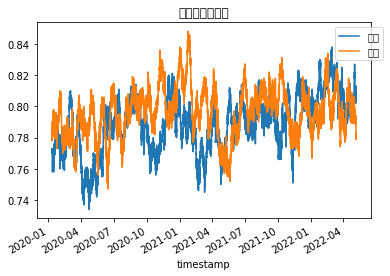

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


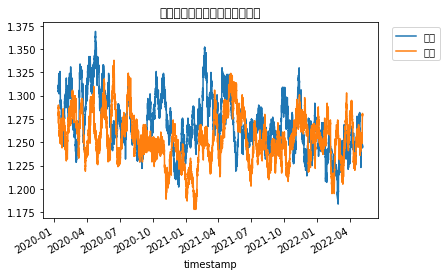

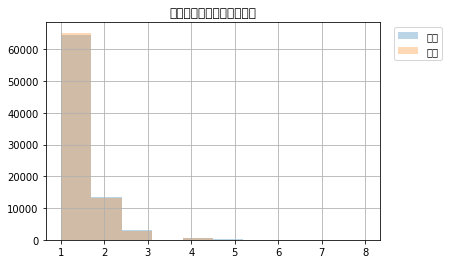

毎時刻、この執行方法でトレードした場合の累積リターン


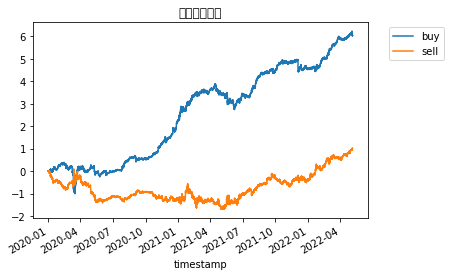

64624
65261


In [51]:
df = pd.read_pickle('df_bf_fx_ohlcv_with_fee.pkl')
df = df.dropna()
df = calc_features(df)
df.to_pickle('df_bf_fx_features.pkl')

@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_bf_fx_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
# limit_price_dist = df['ATR'] * 0.5
# limit_price_dist = df['ATR'] * 0.1
limit_price_dist = df['ATR'] * 0.1557
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()
print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='buy')
df['y_sell'].cumsum().plot(label='sell')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# df = df[df['y_buy']!= 0]
# print('毎時刻、この執行方法でトレードした場合の累積リターン')
# df['y_buy'].cumsum().plot(label='買い')
# df['y_sell'].cumsum().plot(label='売り')
# plt.title('累積リターン')
# plt.legend(bbox_to_anchor=(1.05, 1))
# plt.show()
df

print(len(df[df['y_buy']!=0]))
print(len(df[df['y_sell']!=0]))

df.to_pickle('df_bf_fx_y.pkl')

## モデルの学習とOOS予測値計算

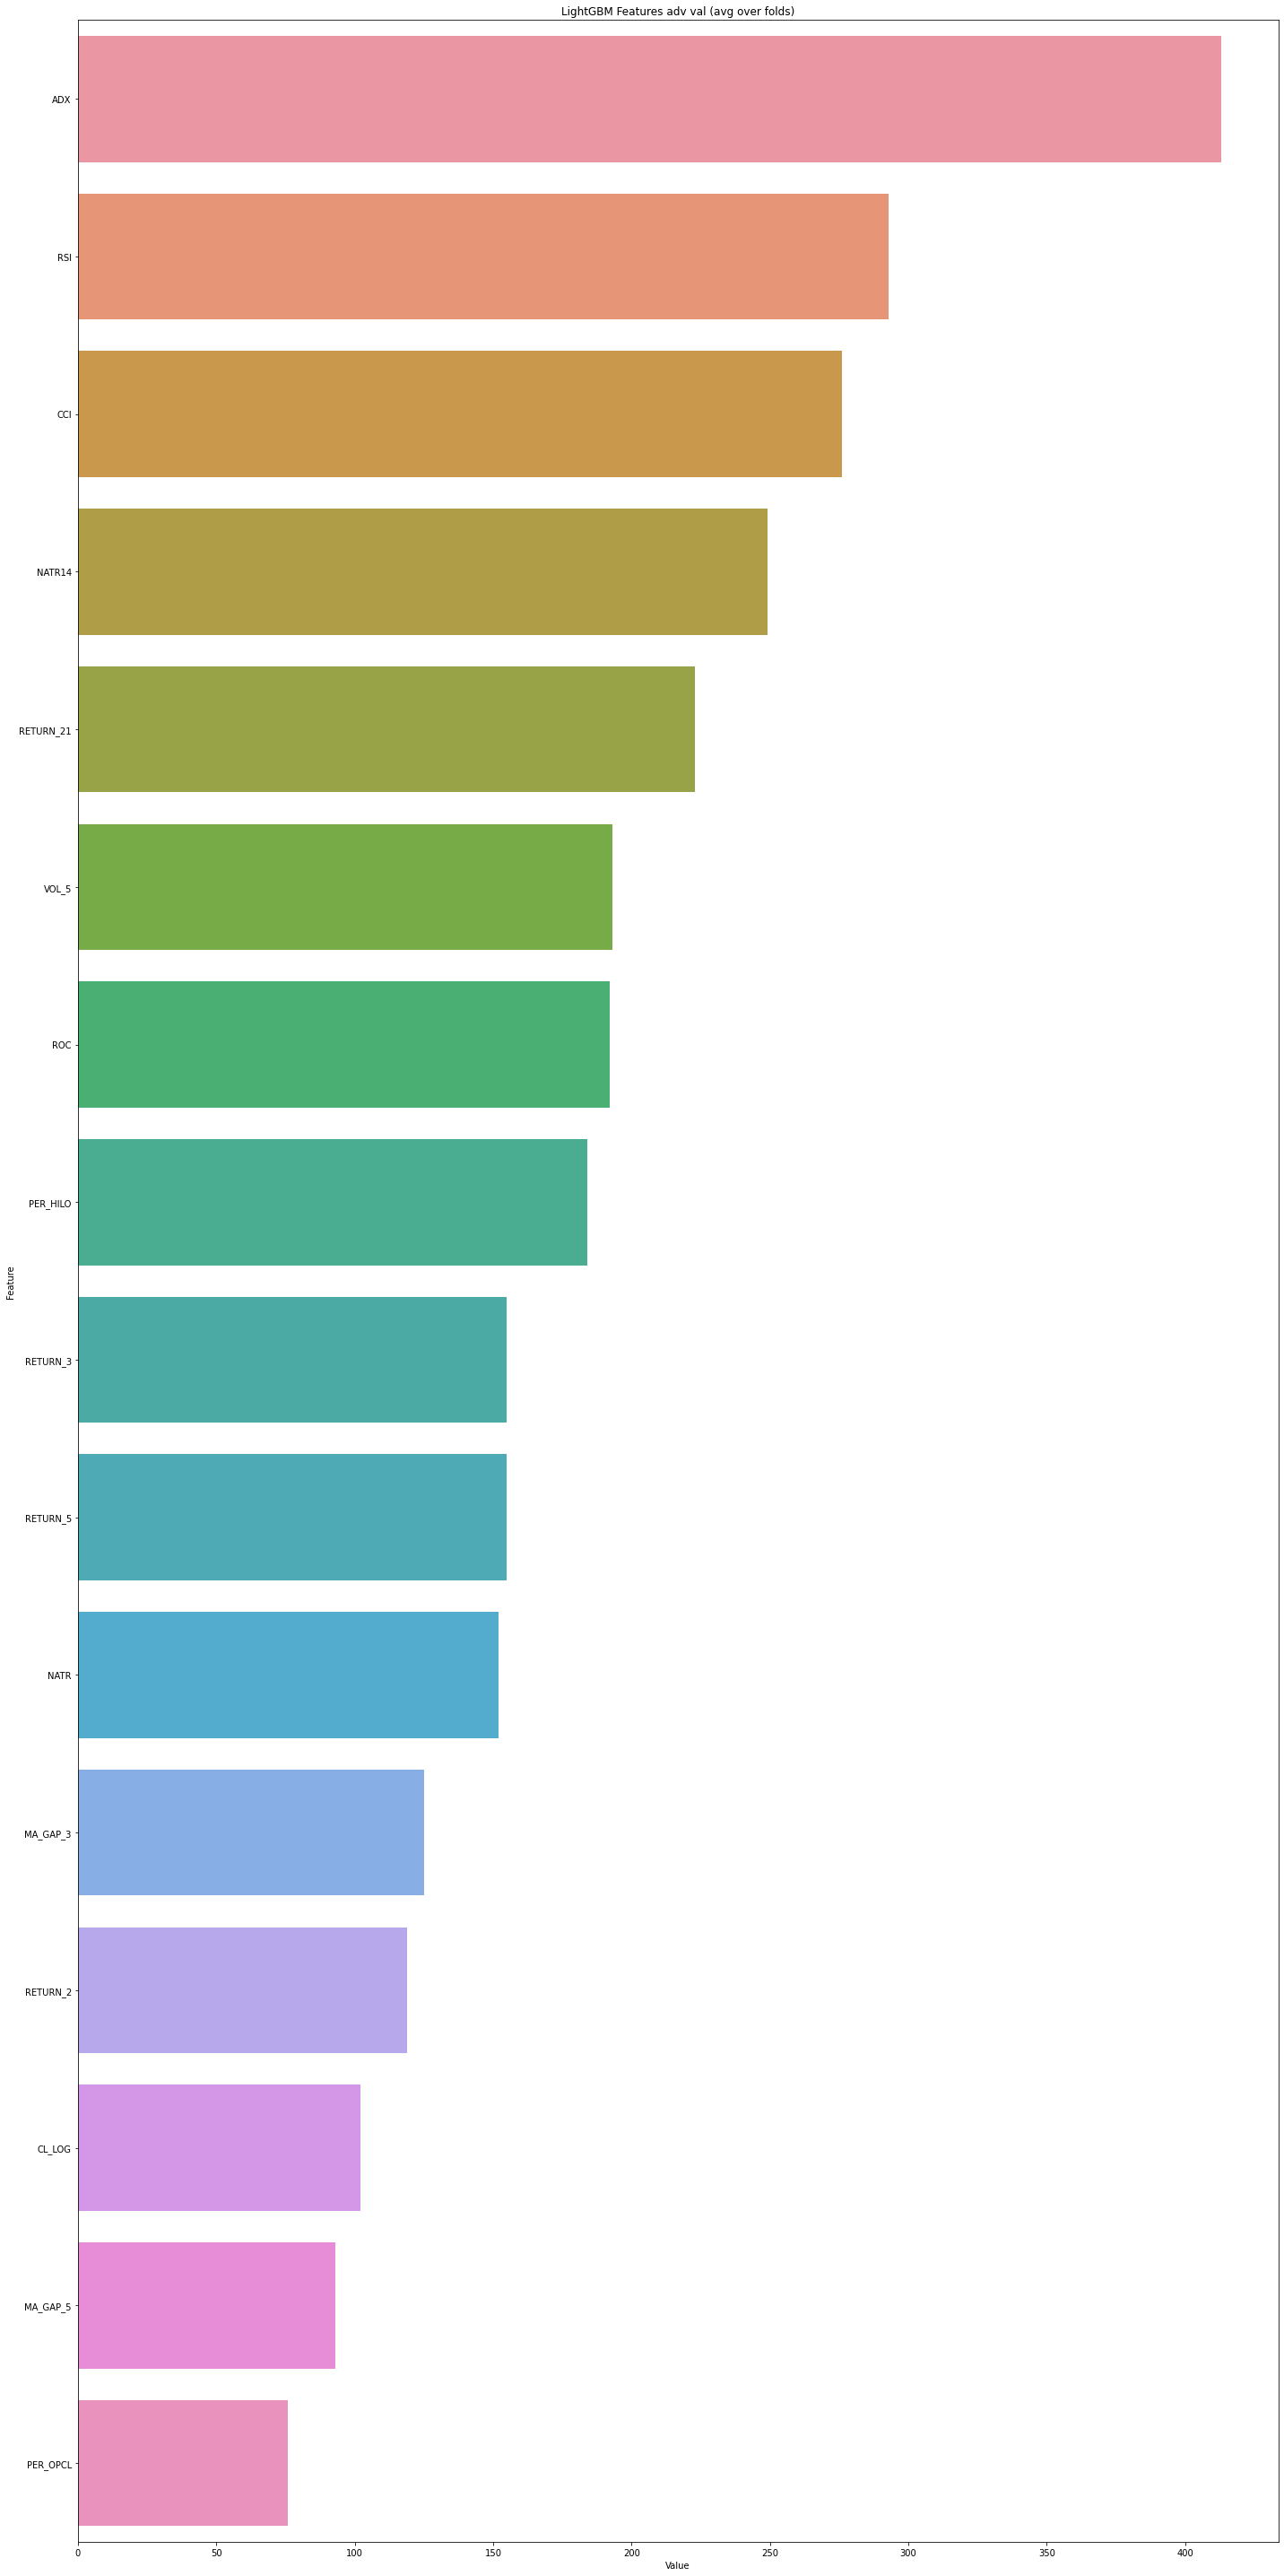

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)
scores [0.10497458 0.10525955]
score mean, std 0.10511706883157451 0.00014248456622761863


In [52]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1)

model.fit(df[features], df['y_buy'])

lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))

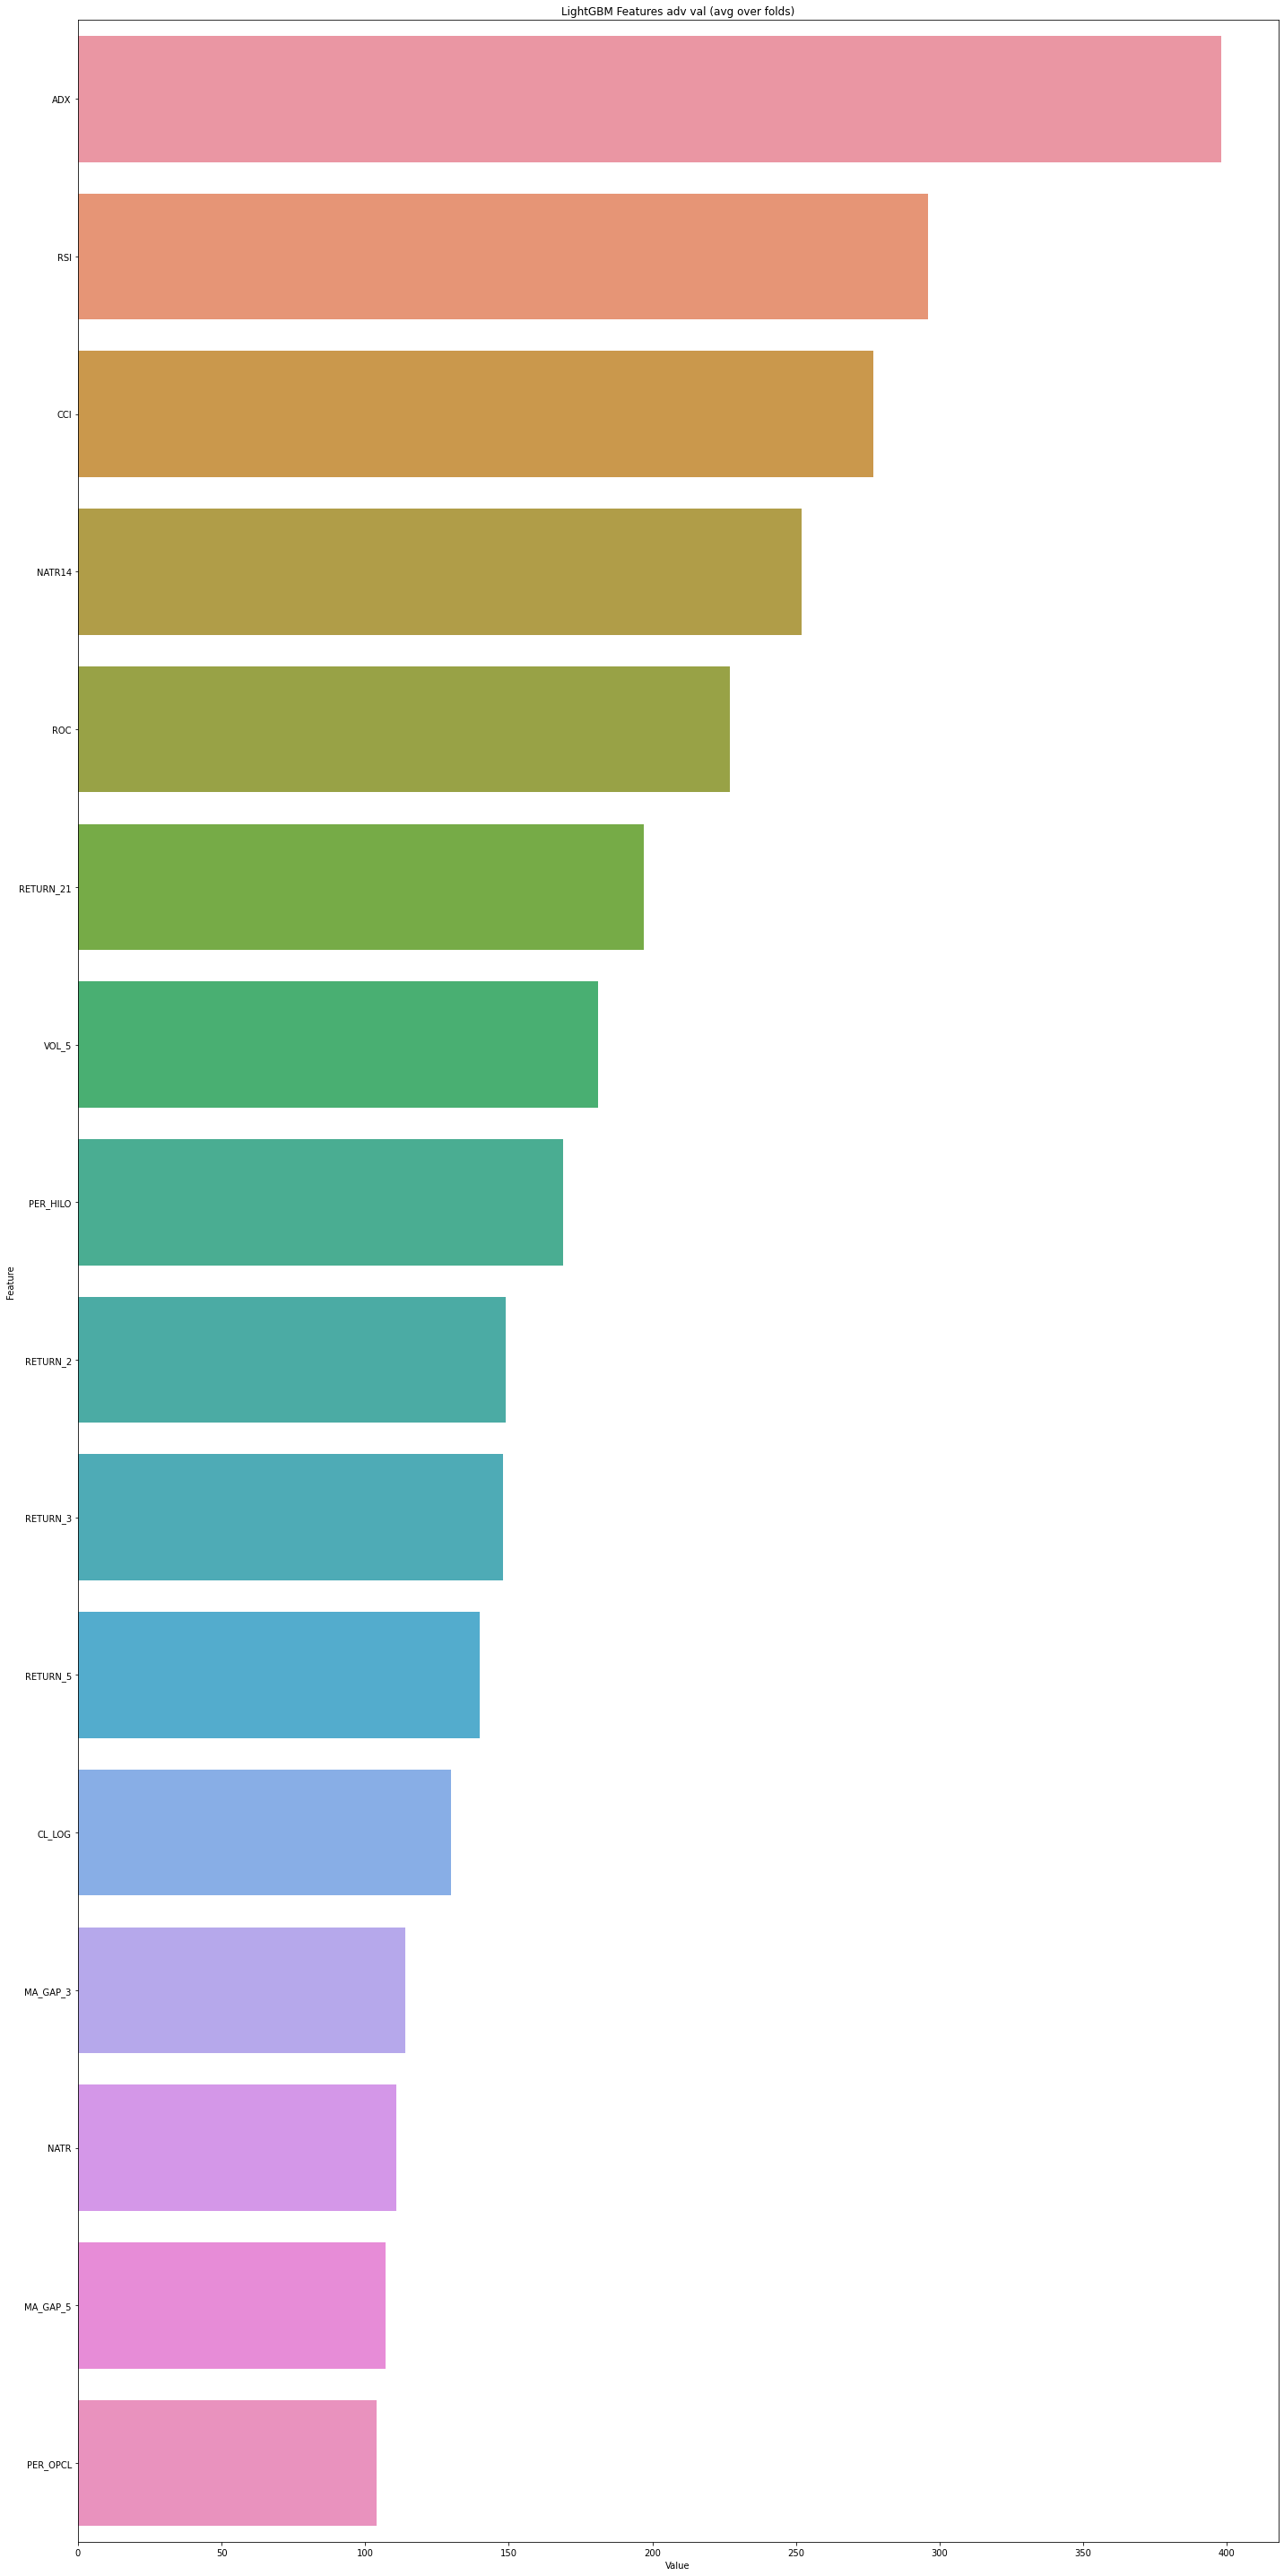

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)
scores [0.10497458 0.10525955]
score mean, std 0.10511706883157451 0.00014248456622761863


In [53]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1)

model.fit(df[features], df['y_sell'])

lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))

In [54]:
# from pycaret.regression import *
# import copy
# df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df.dropna()
# df = df[df.index.year <= 2021]
# features_ybuy = copy.deepcopy(features)
# features_ybuy.append('y_buy')
# exp1 = setup(df[features_ybuy], target = 'y_buy',fold_shuffle=True,)
# model_pycaret = create_model('lightgbm')
# tuned_model = tune_model(model_pycaret, n_iter = 50, optimize = 'mae')
# tuned_model.get_params

In [55]:
import sklearn
print(sklearn.__version__)
!pip show pycaret


1.0.2
Name: pycaret
Version: 2.2.2
Summary: PyCaret - An open source, low-code machine learning library in Python.
Home-page: https://github.com/pycaret/pycaret
Author: Moez Ali
Author-email: moez.ali@queensu.ca
License: MIT
Location: c:\users\cheap\anaconda3\envs\bitflyer_bot\lib\site-packages
Requires: plotly, cufflinks, kmodes, xgboost, spacy, nltk, pyod, lightgbm, imbalanced-learn, pandas, IPython, matplotlib, mlflow, umap-learn, gensim, seaborn, textblob, scikit-plot, joblib, mlxtend, pandas-profiling, pyLDAvis, scikit-learn, catboost, ipywidgets, wordcloud, yellowbrick, numpy
Required-by: 


In [56]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()
df

,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,BBANDS1_upperband,BBANDS1_middleband,BBANDS1_lowerband,BBANDS3_upperband,BBANDS3_middleband,BBANDS3_lowerband,CL_POINT,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,ROC,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR14,NATR14,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,RETURN_2,VOL_2,MA_GAP_2,RETURN_3,VOL_3,MA_GAP_3,RETURN_5,VOL_5,MA_GAP_5,RETURN_8,VOL_8,MA_GAP_8,RETURN_13,VOL_13,MA_GAP_13,RETURN_21,VOL_21,MA_GAP_21,RETURN_55,VOL_55,MA_GAP_55,RETURN_89,VOL_89,MA_GAP_89,hilo,PER_HILO,opcl,PER_OPCL,CL_LOG,buy_price,sell_price,buy_fep,buy_fet,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01 22:15:00+00:00,796974.0,797431.0,796036.0,796041.0,293.640507,0.0,3089.208648,1566.95,-7.966888e+05,2328.079324,1566.95,7.975393e+05,8.005838e+05,798300.45,7.960171e+05,-692.5,1621.012417,1136.132217,1788.139846,1107.248225,1651.533333,950.5,1651.533333,1432.606742,1099.363327,1891.783333,1519.975269,19.983009,22.189256,-393.057692,92.857143,50.000000,-42.857143,-0.668817,-249.791954,13.519295,-132.892292,192.979978,-325.872270,30.597535,18.714869,3476.339638,-2281.0,14.257268,2648.327755,36.644400,-0.340777,19.826477,23.652459,1.245136,19.826477,0.000000,5.908246e-01,0.008717,40.928935,-99.072733,7.507431e+02,-143.918908,9053.761593,1327.188860,0.166724,1304.172751,0.163832,1395.0,23.425065,-19.020141,-237.096667,-1701.708300,-0.325901,0.438055,0,0.801136,0.632948,1320.714286,-89.478675,2749.428571,-109.901099,770.559122,-0.002402,0.000044,0.999414,-0.002430,0.000679,0.998808,-0.002795,0.000613,0.998322,-0.004111,0.000574,0.997765,-0.002926,0.000675,0.997479,-0.004669,0.000757,0.997046,0.003553,0.001128,0.998688,0.005360,0.001159,0.999409,1395.0,0.001751,933.0,0.001171,-0.001171,795838.0,796244.0,795838.0,1.0,794376.0,2.0,1.0,0.0,-0.001837,0.000000,-0.000255,0.000000
2020-01-01 22:30:00+00:00,796038.0,796093.0,793250.0,794093.0,788.935472,0.0,5725.435076,3380.80,-7.936353e+05,4553.117538,3380.80,7.968800e+05,8.015693e+05,798052.30,7.945353e+05,-578.5,3180.142034,2954.478525,3766.004051,3051.578834,3601.533333,2038.5,3601.533333,3192.889216,2449.654689,3901.429167,3305.069892,21.552387,22.575647,-554.974359,100.000000,42.857143,-57.142857,-0.684136,-282.638333,41.954302,-418.426524,70.698678,-489.125202,25.902347,29.933240,6014.029664,-4315.0,12.239825,2459.161487,28.658229,-0.536589,15.958408,21.072508,15.819103,15.958408,0.000000,4.884981e-15,0.008280,36.569492,-86.425121,4.296744e+02,-273.842881,8264.826121,1435.461084,0.180767,1817.115167,0.228829,2843.0,22.515532,-11.148922,-871.768019,-1269.384721,-0.193360,0.557036,0,1.750032,0.750813,2287.485714,-89.731992,5066.657143,-213.782418,1448.139966,-0.003615,0.000904,0.998775,-0.004844,0.000721,0.997977,-0.004825,0.001027,0.996841,-0.005651,0.000895,0.996027,-0.004890,0.000915,0.995412,-0.007851,0.000865,0.994979,-0.000526,0.001157,0.996253,0.003063,0.001189,0.996930,2843.0,0.003578,1945.0,0.002448,-0.002450,793810.0,794376.0,793810.0,1.0,794376.0,1.0,1.0,1.0,0.000213,0.001207,-0.000356,-0.000356
2020-01-01 22:45:00+00:00,794217.0,794439.0,792664.0,793698.0,794.436401,0.0,7208.955642,4236.45,-7.922876e+05,5722.702821,4236.45,7.963017e+05,8.022467e+05,797787.95,7.933292e+05,146.5,3795.096705,3821.060556,4725.991333,4017.708848,4589.866667,2961.0,4589.866667,3897.606411,2876.344241,4944.120833,4129.906452,23.297062,23.090363,-810.076923,100.000000,35.714286,-64.285714,-0.29

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

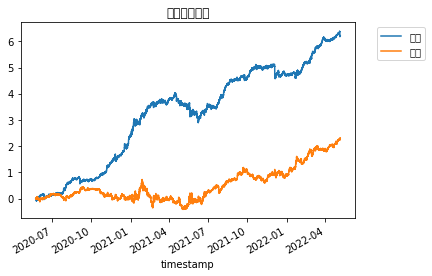

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


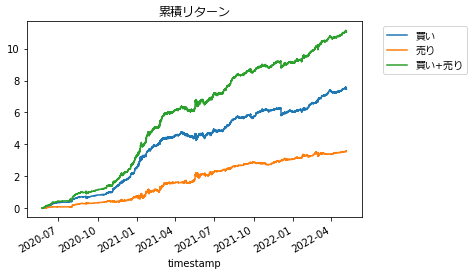

32150
13473


In [57]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()
# print(len(df))
# df = df[df['y_buy']!=0]
# print(len(df))

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
#model = lgb.LGBMRegressor(n_jobs=-1,extra_trees=True)
model = lgb.LGBMRegressor(n_jobs=-1,num_leaves=63,learning_rate=0.01,feature_fraction=0.8,bagging_freq=1,bagging_fraction=0.8,random_state=0,extra_trees=True)
# model = lgb.LGBMRegressor(
#                 class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
#                 importance_type='split', learning_rate=0.05, max_depth=-1,
#                 min_child_samples=26, min_child_weight=0.001, min_split_gain=0.7,
#                 n_estimators=290, n_jobs=-1, num_leaves=20, objective=None,
#                 random_state=8101, reg_alpha=10, reg_lambda=3, silent='warn',
#                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
#                 extra_trees=True
# )

# アンサンブル (コメントアウトを外して性能を比較してみてください)
model = BaggingRegressor(model, random_state=1, n_jobs=1)


# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, './model/model_y_buy_bffx.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, './model/model_y_sell_bffx.xz', compress=True)

# 通常のCV
# cv_indicies = list(KFold().split(df))
# ウォークフォワード法
cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df_buy_fit = df[df['y_buy'] != 0]
df_sell_fit = df[df['y_sell'] != 0]
df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df[df['y_buy']!=0]['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン',fontname="Meiryo")
plt.legend(bbox_to_anchor=(1.05, 1), prop={"family":"Meiryo"})
plt.show()

print(len(df[(df['y_pred_buy'] > 0) & (df['y_buy'] != 0)]))
print(len(df[(df['y_pred_sell'] > 0) & (df['y_sell'] != 0)]))

df.to_pickle('df_bf_fx_fit.pkl')

81875
毎時刻、この執行方法でトレードした場合の累積リターン


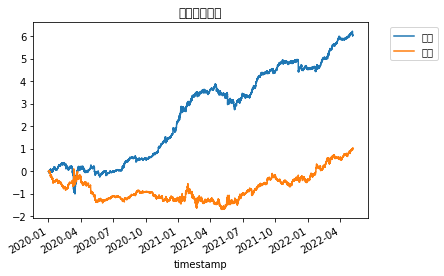

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


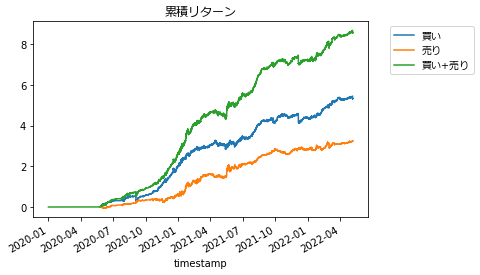

24640
15228


,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,BBANDS1_upperband,BBANDS1_middleband,BBANDS1_lowerband,BBANDS3_upperband,BBANDS3_middleband,BBANDS3_lowerband,CL_POINT,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,ROC,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR14,NATR14,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,RETURN_2,VOL_2,MA_GAP_2,RETURN_3,VOL_3,MA_GAP_3,RETURN_5,VOL_5,MA_GAP_5,RETURN_8,VOL_8,MA_GAP_8,RETURN_13,VOL_13,MA_GAP_13,RETURN_21,VOL_21,MA_GAP_21,RETURN_55,VOL_55,MA_GAP_55,RETURN_89,VOL_89,MA_GAP_89,hilo,PER_HILO,opcl,PER_OPCL,CL_LOG,buy_price,sell_price,buy_fep,buy_fet,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost,y_pred_buy,y_pred_sell
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01 22:15:00+00:00,796974.0,797431.0,796036.0,796041.0,293.640507,0.0,3089.208648,1566.95,-7.966888e+05,2328.079324,1566.95,7.975393e+05,8.005838e+05,798300.45,7.960171e+05,-692.5,1621.012417,1136.132217,1788.139846,1107.248225,1651.533333,950.5,1651.533333,1432.606742,1099.363327,1891.783333,1519.975269,19.983009,22.189256,-393.057692,92.857143,50.000000,-42.857143,-0.668817,-249.791954,13.519295,-132.892292,192.979978,-325.872270,30.597535,18.714869,3476.339638,-2281.0,14.257268,2648.327755,36.644400,-0.340777,19.826477,23.652459,1.245136,19.826477,0.000000,5.908246e-01,0.008717,40.928935,-99.072733,7.507431e+02,-143.918908,9053.761593,1327.188860,0.166724,1304.172751,0.163832,1395.0,23.425065,-19.020141,-237.096667,-1701.708300,-0.325901,0.438055,0,0.801136,0.632948,1320.714286,-89.478675,2749.428571,-109.901099,770.559122,-0.002402,0.000044,0.999414,-0.002430,0.000679,0.998808,-0.002795,0.000613,0.998322,-0.004111,0.000574,0.997765,-0.002926,0.000675,0.997479,-0.004669,0.000757,0.997046,0.003553,0.001128,0.998688,0.005360,0.001159,0.999409,1395.0,0.001751,933.0,0.001171,-0.001171,795838.0,796244.0,795838.0,1.0,794376.0,2.0,1.0,0.0,-0.001837,0.000000,-0.000255,0.000000,0.000000,0.000000
2020-01-01 22:30:00+00:00,796038.0,796093.0,793250.0,794093.0,788.935472,0.0,5725.435076,3380.80,-7.936353e+05,4553.117538,3380.80,7.968800e+05,8.015693e+05,798052.30,7.945353e+05,-578.5,3180.142034,2954.478525,3766.004051,3051.578834,3601.533333,2038.5,3601.533333,3192.889216,2449.654689,3901.429167,3305.069892,21.552387,22.575647,-554.974359,100.000000,42.857143,-57.142857,-0.684136,-282.638333,41.954302,-418.426524,70.698678,-489.125202,25.902347,29.933240,6014.029664,-4315.0,12.239825,2459.161487,28.658229,-0.536589,15.958408,21.072508,15.819103,15.958408,0.000000,4.884981e-15,0.008280,36.569492,-86.425121,4.296744e+02,-273.842881,8264.826121,1435.461084,0.180767,1817.115167,0.228829,2843.0,22.515532,-11.148922,-871.768019,-1269.384721,-0.193360,0.557036,0,1.750032,0.750813,2287.485714,-89.731992,5066.657143,-213.782418,1448.139966,-0.003615,0.000904,0.998775,-0.004844,0.000721,0.997977,-0.004825,0.001027,0.996841,-0.005651,0.000895,0.996027,-0.004890,0.000915,0.995412,-0.007851,0.000865,0.994979,-0.000526,0.001157,0.996253,0.003063,0.001189,0.996930,2843.0,0.003578,1945.0,0.002448,-0.002450,793810.0,794376.0,793810.0,1.0,794376.0,1.0,1.0,1.0,0.000213,0.001207,-0.000356,-0.000356,0.000000,0.000000
2020-01-01 22:45:00+00:00,794217.0,794439.0,792664.0,793698.0,794.436401,0.0,7208.955642,4236.45,-7.922876e+05,5722.702821,4236.45,7.963017e+05,8.022467e+05,797787.95,7.933292e+05,146.5,3795.096705,3821.060556,4725.991333,4017.708848,4589.866667,2961.0,4589.866667,3897.606411,2876.344241,4944.120833,4129.906452,23.29706

In [58]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()
# print(len(df))
df_buy = df[df['y_buy']!=0]
df_sell = df[df['y_sell']!=0]
print(len(df))

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1)
# model = lgb.LGBMRegressor(
#                 class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
#                 importance_type='split', learning_rate=0.05, max_depth=-1,
#                 min_child_samples=26, min_child_weight=0.001, min_split_gain=0.7,
#                 n_estimators=290, n_jobs=-1, num_leaves=20, objective=None,
#                 random_state=8101, reg_alpha=10, reg_lambda=3, silent='warn',
#                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
#                 extra_trees=True
# )

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)


# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
# model.fit(df[features], df['y_buy'])
# joblib.dump(model, './model/model_y_buy_bffx.xz', compress=True) 
# model.fit(df[features], df['y_sell'])
# joblib.dump(model, './model/model_y_sell_bffx.xz', compress=True)

# 通常のCV
# cv_indicies = list(KFold().split(df))
# ウォークフォワード法
cv_indicies_buy = list(TimeSeriesSplit().split(df_buy))
cv_indicies_sell = list(TimeSeriesSplit().split(df_sell))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df_buy_fit = df[df['y_buy'] != 0]
df_sell_fit = df[df['y_sell'] != 0]
df_buy['y_pred_buy'] = my_cross_val_predict(model, df_buy[features].values, df_buy['y_buy'].values, cv=cv_indicies_buy)
df_sell['y_pred_sell'] = my_cross_val_predict(model, df_sell[features].values, df_sell['y_sell'].values, cv=cv_indicies_sell)

df = pd.merge(df, df_buy['y_pred_buy'], left_index=True, right_index=True, how='left')
df = pd.merge(df, df_sell['y_pred_sell'], left_index=True, right_index=True, how='left')
df['y_pred_buy'] = df['y_pred_buy'].fillna(0)
df['y_pred_sell'] = df['y_pred_sell'].fillna(0)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df_buy['y_buy'].cumsum().plot(label='買い')
df_sell['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン',fontname="Meiryo")
plt.legend(bbox_to_anchor=(1.05, 1), prop={"family":"Meiryo"})
plt.show()

print(len(df[(df['y_pred_buy'] > 0) & (df['y_buy'] != 0)]))
print(len(df[(df['y_pred_sell'] > 0) & (df['y_sell'] != 0)]))

# df.to_pickle('df_bf_fx_fit.pkl')
df

## バックテストと検定

1.0138862704660419


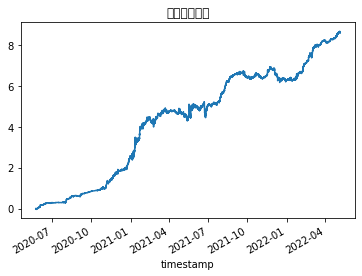

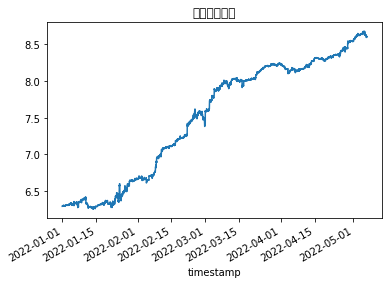

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


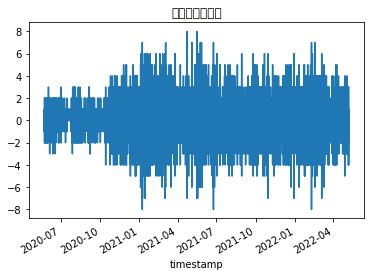

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


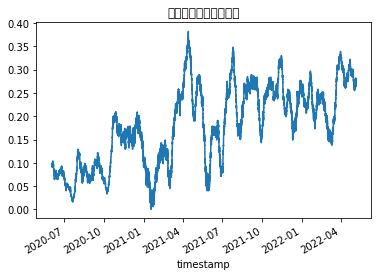

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


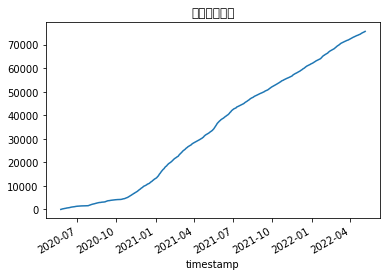

t検定
t値 5.339625073889578
p値 9.343603270772181e-08
p平均法 n = 5
p平均 0.11230490796222192
エラー率 0.0004652243705492899


In [71]:
#@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None,
              date_time=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    old_ret = 0.0
    print_date = '2022-03-01 00:00:00'
    print_ret = 0.0

    for i in range(n):
        prev_pos = pos

        # exit
        if buy_cost[i]:
        #if sell_entry[i] < 0 and buy_cost[i]:
        #if buy_entry[i] < 0 and buy_cost[i]:
            #vol = np.minimum(1.0, 1 - prev_pos) * (buy_entry[i] > 0)
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
        #if buy_entry[i] < 0 and sell_cost[i]:
        #if sell_entry[i] < 0 and sell_cost[i]:
            #vol = np.minimum(1.0, prev_pos + 1) * (sell_entry[i] > 0)
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] > 0 and buy_cost[i]:
        #if buy_entry[i] > 0 and buy_cost[i] and buy_entry[i] >= sell_entry[i]:
            vol = np.minimum(2.0, 1 - prev_pos) * (buy_entry[i] > 0)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] > 0 and sell_cost[i]:
            vol = np.minimum(2.0, prev_pos + 1) * (sell_entry[i] > 0)
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos

        if date_time[i] > print_date:
            print_ret += (ret - old_ret)
        old_ret = ret
            

    print(print_ret)
    return y, poss

df = pd.read_pickle('df_bf_fx_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df_index = df
df_index['datetime'] = pd.to_datetime(df_index.index)
df_index['datetime'] = df_index['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    # buy_entry=df['y_pred_buy'].values > 0,
    # sell_entry=df['y_pred_sell'].values > 0,
    buy_entry=df['y_pred_buy'].values,
    sell_entry=df['y_pred_sell'].values,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
    date_time=df_index['datetime'].values,
)


df['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

df[df.index.year == 2022]['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('ポジション推移')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('ポジション平均の推移')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('取引量の累積')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


## 実運用

In [72]:
# 最大ポジションサイズと月次利益の見積もり例
amount_per_day_jpy = 1000.0 * 10000 * 10000 # 1日の売買代金 1000億円
order_interval_min = 15.0 # 15分間隔で発注
monthly_return = 0.5 # 月次利益率 50%
my_order_ratio = 0.01 # 自分のボットの売買代金割合 1%

max_position_size = amount_per_day_jpy / (24 * 60) * order_interval_min * my_order_ratio
monthly_profit = max_position_size * monthly_return
print('最大ポジションサイズ {}円'.format(max_position_size))
print('月次利益 {}円'.format(monthly_profit))

最大ポジションサイズ 10416666.666666668円
月次利益 5208333.333333334円


##　売買判定 

BitFlyerが用意しているAPIからOHLCVを取得しモデルを利用して売買判定を出力します。
買い予想の数値(y_pred_buy)が0以上であれば買い、売り予想の数値(y_pred_sell)が0以上であれば売りと判断しています。
このためポジションの出力では買い予想の数値(y_pred_buy)のみが0以上の時に買い、売り予想の数値(y_pred_sell)のみが0以上の時に売りと判断しています。

In [73]:
#OHLCV取得
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
unixtime = datetime.datetime.now().timestamp() * 1000
target_coin = "FX_BTC_JPY"
ohlc_list=[]

#1000本以上の1分足を取得
while len(ohlc_list) < 1000:
    response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
    ohlc_list.extend(response)
    current_after = datetime.datetime.fromtimestamp(response[-1][0]/1000)
    next_before = current_after - timedelta(minutes=1)
    unixtime = int(next_before.timestamp() * 1000)
    time.sleep(1)

df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
df_1m.set_index("timestamp",inplace=True)
df_1m.sort_index(inplace=True)

#15分足に変換
df = pd.DataFrame()
rule = "15T"
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

#特徴量の計算
df_features = calc_features(df)

#モデルの読み込み
model_y_buy = joblib.load('./model/model_y_buy_bffx.xz')
model_y_sell = joblib.load('./model/model_y_sell_bffx.xz')

#推論
df_features["predict_y_buy"] = model_y_buy.predict(df_features[features])
df_features["predict_y_sell"] = model_y_sell.predict(df_features[features])

#ポジションの判定

#買いポジションの判定
def calc_position_buy(x):
    buy = x["predict_y_buy"]
    if buy > 0:
        return "buy"
    else:
        return "none"
    
#売りポジションの判定
def calc_position_sell(x):
    buy = x["predict_y_sell"]
    if buy > 0:
        return "sell"
    else:
        return "none"

df_features["position_buy"] = df_features.apply(calc_position_buy,axis=1)
df_features["position_sell"] = df_features.apply(calc_position_sell,axis=1)

display(df_features)

position_buy = df_features["position_buy"].iloc[-1]
position_sell = df_features["position_sell"].iloc[-1]

if position_buy == "buy" and position_sell == "none":
    print("Buy Bitcoin")
elif position_sell == "sell" and position_buy == "none":
    print("Sell Bitcoin")
else:
    print("N/A")


,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,BBANDS1_upperband,BBANDS1_middleband,BBANDS1_lowerband,BBANDS3_upperband,BBANDS3_middleband,BBANDS3_lowerband,CL_POINT,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,ROC,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR14,NATR14,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,RETURN_2,VOL_2,MA_GAP_2,RETURN_3,VOL_3,MA_GAP_3,RETURN_5,VOL_5,MA_GAP_5,RETURN_8,VOL_8,MA_GAP_8,RETURN_13,VOL_13,MA_GAP_13,RETURN_21,VOL_21,MA_GAP_21,RETURN_55,VOL_55,MA_GAP_55,RETURN_89,VOL_89,MA_GAP_89,hilo,PER_HILO,opcl,PER_OPCL,CL_LOG,predict_y_buy,predict_y_sell,position_buy,position_sell
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-08 12:00:00+00:00,4596945.0,4608675.0,4595269.0,4607463.0,34.720330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.784574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.442389,NaN,34.720330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13406.0,0.002913,-10518.0,-0.002286,NaN,1.087448e-05,-6.320032e-05,buy,none
2022-05-08 12:15:00+00:00,4606685.0,4608623.0,4583011.0,4589069.0,47.994814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6748.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.687803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.151978,NaN,-13.274483,NaN,NaN,NaN,NaN,25612.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25612.0,0.005573,17616.0,0.003833,-0.004000,1.599964e-05,3.713101e-05,buy,sell
2022-05-08 12:30:00+00:00,4588629.0,4590344.0,4577801.0,4588443.0,48.702730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4370.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.092069,NaN,-61.977213,NaN,NaN,NaN,NaN,12543.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004128,0.002732,0.999932,NaN,NaN,0.998575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12543.0,0.002736,186.0,0.000041,-0.000136,-4.596839e-07,-1.463082e-05,none,none
2022-05-08 12:45:00+00:00,4588218.0,4592780.0,4575754.0,4582407.0,64.125549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1860.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.341302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.081318,NaN,-126.102763,NaN,NaN,18393.666667,0.401397,17026.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001452,0.000834,0.999342,-0.005438,0.001980,0.999077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17026.0,0.003714,5811.0,0.001268,-0.001316,4.371617e-05,-2.188823e-05,buy,none
2022-05-08 13:00:00+00:00,4582407.0,4586893.0,4573107.0,4583027.0,65.305081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.759467,NaN,-60.797682,NaN,NaN,16857.777778,0.367831,13786.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,9104.837185,-0.001180,0.001026,1.000068,-0.001317,0.000772,0.999651,NaN,NaN,0.998463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Buy Bitcoin


In [77]:
#初回だけ実行
#!pip install optuna

import optuna
optuna.logging.disable_default_handler()
import warnings
warnings.filterwarnings('ignore')


def calc_y(df,param):
    # 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
    pips = 0.01

    # ATRで指値距離を計算します
    limit_price_dist = df['ATR'] * param['atr']
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['cl'] - limit_price_dist
    df['sell_price'] = df['cl'] + limit_price_dist

    #df['buy_price'] = df['cl'] + df['BBANDS_lowerband'] 
    #df['sell_price'] = df['cl'] + limit_price_dist 

    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['lo'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['hi'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1

    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料

    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['cl'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['cl'] - 1) + fee,
        0
    )
    return df

df_features = pd.read_pickle('df_bf_fx_features.pkl')
df_features = df_features[df_features.index > pd.to_datetime('2022-03-01 00:00:00Z')]
def objective(trial):
    atr = trial.suggest_uniform('atr', 0.0, 2.0)
    param = {"atr":atr}
    df = calc_y(df_features,param)
    score = df['y_buy'].cumsum().iloc[-1] + df['y_sell'].cumsum().iloc[-1]
    print("atr:{} score{}".format(atr,score))
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
# プログラムが試行錯誤した結果最も良いパラメータを表示
print("best param: {}".format(study.best_params))
# 最も良いパラメータで実行したときの結果（返り値）を表示
print("best score: {}".format(study.best_value))

atr:0.7233564862495026 score-0.7252299430423776
atr:1.3955710575137907 score-0.7506042037395174
atr:0.7103659314346447 score-0.7755067529563171
atr:0.3647177273465052 score0.01488469626698452
atr:1.0206845828700193 score-0.6130552071080058
atr:1.0855726640856824 score-0.8074575458349783
atr:0.9962018383467102 score-0.6267447226222495
atr:0.2658395097791417 score0.8031325978140769
atr:0.868179354526792 score-0.8872942425111673
atr:1.6131387761941711 score-0.23346520399435755
atr:0.0006137983203978181 score-1.3623446487681337
atr:0.22962850140308527 score0.8390547791564087
atr:0.026268873961960343 score-0.2093916118736081
atr:0.3924544871658554 score-0.12546278526435883
atr:0.34455986513650505 score0.4631269363300553
atr:1.868997356272713 score0.586512259225764
atr:0.2193671874606875 score0.8529515752717804
atr:0.5792966861661955 score-0.20156621621855275
atr:0.1536172425260559 score1.4291911382534037
atr:0.5315956514429613 score0.11993045009504189
atr:1.3524478902974006 score-0.41614891